In [1]:
!pip install catboost

     |████████████████████████████████| 62.9MB 59.1MB/s 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import log_loss
from sklearn import cluster
from scipy.sparse import csr_matrix, hstack

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.svm import SVR
import catboost
from catboost import CatBoostClassifier

In [0]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
# sample_sub = pd.read_csv('SampleSubmission.csv')


In [43]:
train_data.head()

,check_id,customer_id,time,category_1,category_2,barcode,count,target,barcode_len,is_cust_id,first_2_barcode,new_time,hours,day,day_week
0,eed1876f9ae5798f0835d7892f75c4a1,NaN,10:01,все для компьютеров,2643,4316875210,1,8,10,0,43,601,10,0,0
1,592f80a1744e13bced5260784b85c340,NaN,10:01,доставка,4463,1200081331,1,4,10,0,12,601,10,0,0
2,95a46543a4b9af29a40206d18f99fb3f,NaN,10:01,доставка,4124,1200001311,1,4,10,0,12,601,10,0,0
3,eed1876f9ae5798f0835d7892f75c4a1,NaN,10:01,все для компьютеров,1913,4613510253,1,8,10,0,46,601,10,0,0
4,107ae1a8613d936460ef9cd923bfe3b9,NaN,10:01,доставка,3856,4900005537,1,4,10,0,49,601,10,0,0


In [0]:
def data_preprocessing(data_name):
  '''создание необходимых колонок в начальном датасете для последнующей обработки'''
  data_name['barcode_len'] = data_name['barcode'].apply(lambda x: len(str(x)))
  data_name['is_cust_id'] = np.where(pd.notnull(data_name['customer_id']), 1, 0)
  data_name['first_2_barcode'] = data_name['barcode'].astype('str').apply(lambda x: x[:2])
  
  data_name['is_food'] = np.where((data_name['category_1'] == 'молочные продукты') | 
                                  (data_name['category_1'] == 'кондитерские изделия и сладости')|
                                  (data_name['category_1'] == 'крупы, каши, орехи')|
                                  (data_name['category_1'] == 'кулинария')|
                                  (data_name['category_1'] == 'свежая еда')|
                                  (data_name['category_1'] == 'запакованная еда')|
                                  (data_name['category_1'] == 'фрукты и овощи')|
                                  (data_name['category_1'] == 'хлебобулочные изделия')|
                                  (data_name['category_1'] == 'алкоголь')|
                                  (data_name['category_1'] == 'свежее и замороженное мясо')|
                                  (data_name['category_1'] == 'морепродукты'), 1, 0)
  data_name['is_clothes'] = np.where((data_name['category_1'] == 'одежда для мужчин') | 
                                  (data_name['category_1'] == 'обувь')|
                                  (data_name['category_1'] == 'одежда для малышей')|
                                  (data_name['category_1'] == 'женские носки')|
                                  (data_name['category_1'] == 'женская одежда')|
                                  (data_name['category_1'] == 'одежда для мальчиков')|
                                  (data_name['category_1'] == 'одежда для беременных')|
                                  (data_name['category_1'] == 'пижамы')|
                                  (data_name['category_1'] == 'нижнее белье')|
                                  (data_name['category_1'] == 'купальники')|
                                  (data_name['category_1'] == 'колготки и чулки')|
                                  (data_name['category_1'] == 'мужская одежда'), 1, 0)
  data_name['children_goods'] = np.where((data_name['category_1'] == 'детские товары') | 
                                  (data_name['category_1'] == 'товары для праздника')|
                                  (data_name['category_1'] == 'одежда для малышей')|
                                  (data_name['category_1'] == 'товары для развлечений')|
                                  (data_name['category_1'] == 'игровые приставки'), 1, 0)


In [46]:
data_preprocessing(train_data), data_preprocessing(test_data)

(None, None)

In [0]:
### Обработка данных

def time_creator(data_name):
    new_format = pd.to_datetime(data_name['time'])
    data_name['new_time'] = new_format.dt.hour * 60 + new_format.dt.minute
    data_name['hours'] = new_format.dt.hour
    data_name['day'] = np.cumsum(np.where(np.diff(data_name['new_time'], prepend = True)<0, 1, 0))
#     data_name['day'] = data_name['day'].astype('str').apply(lambda x : x)
    data_name['day_week'] = data_name['day']%7
    return data_name
#     .astype('str').apply(lambda x : len(x))

def small_matrix (data_name, feature):
    name_matrix = pd.get_dummies(data_name[feature], prefix = feature[:2]).groupby(data_name['check_id']).apply(max)
    return name_matrix

def matrix_flow (data_name, feature, iterations = 26):
    """функция для больших матриц
    число разбиений"""
    left_boarder = -1
    right_boarder = 199
    for i in range (iterations):
        new_matrix = pd.get_dummies(data_name[(data_name[feature] >= left_boarder) &
                                               (data_name['category_2'] < right_boarder)]['category_2'])\
                                                .groupby(data_name['check_id']).apply(max)
        left_boarder += 200
        right_boarder += 200
        yield new_matrix


def final_matrix_create (data_name):
    '''feature = category_1'''
#     создаем первую матрицу-основу по cat_1
    category_matrix = small_matrix(data_name, 'category_1')
#     начинаем примердживать к ней другие фичи:
#     cat_2
    for i in matrix_flow(data_name, 'category_2'):
        category_matrix = category_matrix.merge(i, how = 'outer', left_index=True, right_index=True)

#     календарь:
#     день месяца(из 31)
    time_data = time_creator(data_name)
    category_matrix['day'] = time_data.drop_duplicates('check_id').\
                                            sort_values('check_id')['day'].values
#     день недели(из 7)
    category_matrix['day_week'] = time_data.drop_duplicates('check_id').\
                                            sort_values('check_id')['day_week'].values
#     точное время 
    time = small_matrix(time_data, 'hours')
    category_matrix = category_matrix.merge(time, how = 'outer', left_index=True, right_index=True)
    
#     длина баркода
    barcode_len = small_matrix(data_name, 'barcode_len')
    category_matrix = category_matrix.merge(barcode_len, how = 'outer', left_index=True, right_index=True)
    
#     есть ли cust_id
    
    category_matrix['is_cust_id'] = data_name.drop_duplicates('check_id').\
                                            sort_values('check_id')['is_cust_id'].values
    
#     if data_name == train_data:
#         category_matrix['target'] = data_name.drop_duplicates('check_id').sort_values('check_id')['target'].values
#     else:
#         continue

    first_2_barcode_num = small_matrix(data_name, 'first_2_barcode')
    category_matrix = category_matrix.merge(first_2_barcode_num, how = 'outer', left_index=True, right_index=True)

#     проверка на укрупненные категории (еда, одежда, детские товары)    
    category_matrix['is_food'] = data_name.sort_values(by = 'is_food', ascending = True).drop_duplicates('check_id').\
                                                                                  sort_values(by = 'check_id')['is_food'].values
  
    category_matrix['is_clothes'] = data_name.sort_values(by = 'is_clothes', ascending = True).drop_duplicates('check_id').\
                                                                                  sort_values(by = 'check_id')['is_clothes'].values
    
    category_matrix['children_goods'] = data_name.sort_values(by = 'children_goods', ascending = True).drop_duplicates('check_id').\
                                                                                  sort_values(by = 'check_id')['children_goods'].values    
    
    
    category_matrix.fillna(value = 0 , inplace=True)
#     category_matrix.reset_index(inplace=True)
    
    return category_matrix
    

In [0]:
category_matrix = final_matrix_create(train_data)

In [0]:
category_matrix_test = final_matrix_create(test_data)

In [0]:
# category_matrix.to_string()

In [0]:
# Приведение валидационной и тестовой матриц к общему виду:

new_row = category_matrix.iloc[:1,:] 
category_matrix_test = new_row.append(category_matrix_test,sort=False)

category_matrix_test.fillna(value = 0 , inplace=True)

train_matr_col = set(category_matrix.columns)
test_matr_col = set(category_matrix_test.columns)
list_of_diff = []
for i in test_matr_col:
    if i not in train_matr_col:
        list_of_diff.append(i)

category_matrix_test.drop(list_of_diff, axis = 1 ,inplace = True)


category_matrix_test.shape

category_matrix_test.drop('00001bf75a88b618291460d7891caedb', axis = 0, inplace = True)

category_matrix = category_matrix.astype('uint8')
category_matrix_test = category_matrix_test.astype('uint8')

category_matrix['target'] = train_data.drop_duplicates('check_id').sort_values('check_id')['target'].values



In [56]:
category_matrix_test.shape

(13483, 5143)

In [0]:
### Модель

X = category_matrix.drop(['target'],axis=1)
y = category_matrix.target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)



In [0]:
params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'ctr_border_count':[50,5,10,20,100,200],
          'thread_count':4}

In [0]:
clf= CatBoostClassifier(iterations=1000, learning_rate = 0.03, max_depth=12,
                             loss_function = 'MultiClass', verbose = True, use_best_model = True,
                        random_seed= 42,
                            task_type = 'GPU')



In [70]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
clf.fit(X_train, y_train,eval_set=(X_val,y_val))


0:	learn: 3.0492141	test: 3.0506867	best: 3.0506867 (0)	total: 896ms	remaining: 14m 54s
1:	learn: 2.9244294	test: 2.9274917	best: 2.9274917 (1)	total: 1.9s	remaining: 15m 47s
2:	learn: 2.8224488	test: 2.8271661	best: 2.8271661 (2)	total: 2.89s	remaining: 15m 59s
3:	learn: 2.7362806	test: 2.7425534	best: 2.7425534 (3)	total: 3.88s	remaining: 16m 6s
4:	learn: 2.6637468	test: 2.6711959	best: 2.6711959 (4)	total: 5.01s	remaining: 16m 37s
5:	learn: 2.5932062	test: 2.6017717	best: 2.6017717 (5)	total: 6s	remaining: 16m 34s
6:	learn: 2.5340176	test: 2.5435473	best: 2.5435473 (6)	total: 6.81s	remaining: 16m 5s
7:	learn: 2.4795857	test: 2.4898229	best: 2.4898229 (7)	total: 7.85s	remaining: 16m 13s
8:	learn: 2.4322030	test: 2.4434398	best: 2.4434398 (8)	total: 8.97s	remaining: 16m 27s
9:	learn: 2.3882245	test: 2.4002729	best: 2.4002729 (9)	total: 10.3s	remaining: 16m 59s
10:	learn: 2.3481892	test: 2.3609022	best: 2.3609022 (10)	total: 11.4s	remaining: 17m 4s
11:	learn: 2.3090904	test: 2.3226040	

Text(0.5, 0, 'Importance')

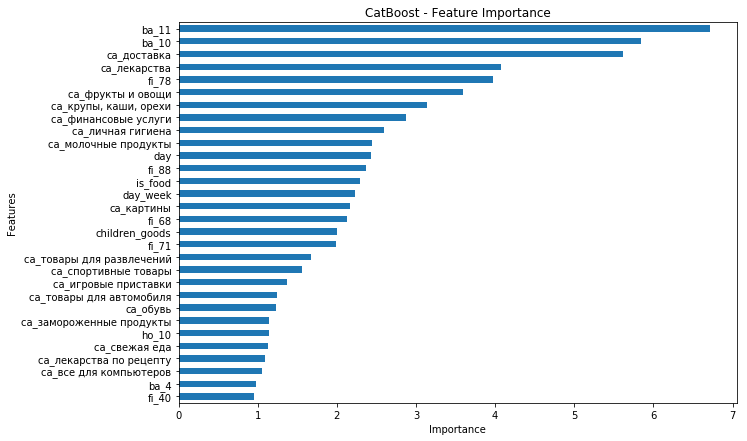

In [59]:
fea_imp = pd.DataFrame({'imp': clf.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')



In [0]:
category_matrix_test.reset_index(inplace=True)
row_names = category_matrix_test.check_id
category_matrix_test.drop('check_id',axis = 1,inplace=True)
to_sub = clf.predict_proba(category_matrix_test)

In [0]:
ids = row_names
columns_names = ['target_{}'.format(i) for i in range(25)]

df_result = pd.DataFrame(to_sub, columns=columns_names)
df_result.insert(0, 'check_id', ids)
df_result.head(10)

df_result.to_csv('submission_9.csv', index=False)



In [65]:
pd.read_csv('submission_9.csv').shape

(13483, 26)